# Conformal prediction
## 1. Generate artificial samples

In [1]:
clear()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time 
from sklearn.neighbors import KNeighborsRegressor

Text(0.5, 1.0, 'Simulated Data for K-NN Regression')

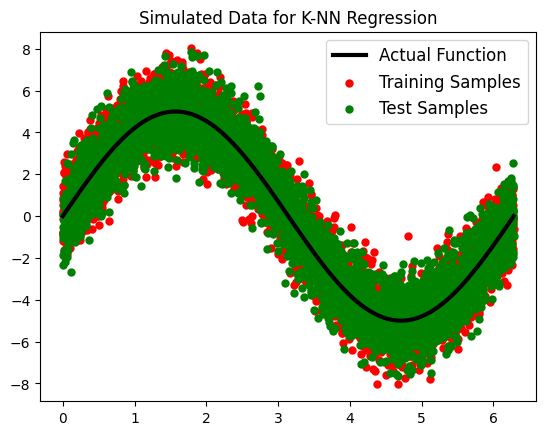

In [3]:
# first, let's simulate a simple dataset

# Use the current time stamp as the random seed for generating the dataset
np.random.seed(seed=1) 

n = 5000
x_train = np.random.uniform(0, 2*np.pi, n)
x_train = np.sort( x_train )
y_train = 5*np.sin( x_train ) + np.random.normal(size=n)

plt.plot(x_train, 5*np.sin(x_train), color = 'black', label = 'Actual Function', linewidth=3)
plt.scatter(x_train, y_train, color = 'red', marker='.', label = 'Training Samples', linewidth=3)


x_test = np.random.uniform(0, 2*np.pi, n)
x_test = np.sort( x_test )
y_test = 5*np.sin( x_test ) + np.random.normal(size=n)
plt.scatter(x_test, y_test, color = 'green', marker='.', label = 'Test Samples', linewidth=3)
plt.legend(fontsize = 12)
plt.title( 'Simulated Data for K-NN Regression' )

(array([ 42., 451., 845., 655., 522., 516., 598., 844., 477.,  50.]),
 array([-8.05068853, -6.44428501, -4.8378815 , -3.23147799, -1.62507447,
        -0.01867096,  1.58773256,  3.19413607,  4.80053958,  6.4069431 ,
         8.01334661]),
 <BarContainer object of 10 artists>)

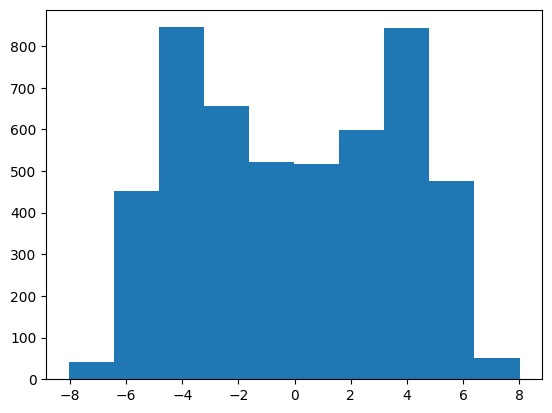

In [5]:
plt.hist(y_train)

## 2. Simple example

#### 2.1 compute $q$ for $|Y|$ from the training sample and apply it to the test sample

In [6]:
q=np.quantile(abs(y_train), 0.95)
sum(abs(y_train<=q)/len(y_train))

0.9727999999999255

In [7]:
sum((y_test >= -q) & (y_test <= q))/len(y_test)

0.9512

In [8]:
# length of [-q, q]
2*q

11.794981728263252

#### 2.2 another idea?

In [9]:
q1 = np.quantile((y_train), 0.025) # 2.5% quantile of Y
q2 = np.quantile((y_train), 0.975) # 97.5% quantile of Y
sum((y_test >= q1) & (y_test <= q2))/len(y_test)

0.9516

In [10]:
# length of [q1, q2]
q2-q1

11.786603542808958

#### 2.3 Using X

In [11]:
from sklearn.model_selection import train_test_split
trainA_x, trainB_x, trainA_y, trainB_y = train_test_split(x_train, y_train, test_size=0.4, random_state = 213)
# A used to train, B used to find quantile

In [28]:
knnReg = KNeighborsRegressor(20, weights='uniform')
knnReg.fit(trainA_x.reshape(-1,1), trainA_y)
type(trainA_y)

numpy.ndarray

In [13]:
# apply conformal prediction to data in B
pred_B = knnReg.predict(trainB_x.reshape(-1,1))
pred_err  = trainB_y-pred_B

q=np.quantile(abs(pred_err), 0.95)

In [14]:
# conformal prediction on test data
pred_test = knnReg.predict(x_test.reshape(-1,1))
upper_b = pred_test+q
lower_b = pred_test-q

sum((y_test >= lower_b) & (y_test <= upper_b))/len(y_test)

0.9476

(array([534., 477., 451., 506., 474., 505., 497., 516., 536., 504.]),
 array([4.95967705e-04, 6.28499364e-01, 1.25650276e+00, 1.88450616e+00,
        2.51250955e+00, 3.14051295e+00, 3.76851635e+00, 4.39651974e+00,
        5.02452314e+00, 5.65252653e+00, 6.28052993e+00]),
 <BarContainer object of 10 artists>)

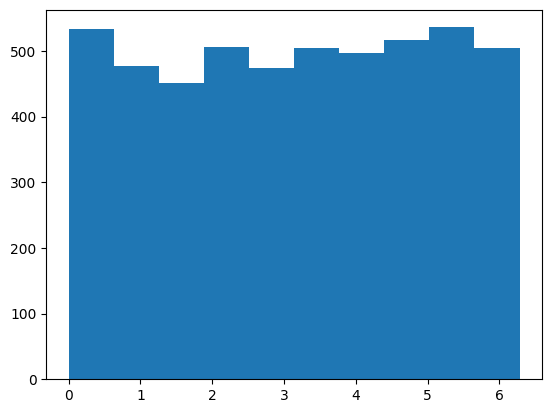

In [15]:
plt.hist(x_test)

In [16]:
# consider the coverage probability if C = [-q, q] when X is low (X<0.5)
y_test_new = y_test[x_test<2]
sum((y_test_new>=q1) & (y_test_new<=q2))/len(y_test_new)

0.9355670103092784

#### 2.3 fancier idea?

In [1]:
import os
path = os.chdir("/Users/ericwang/Desktop/ECON_148/L4.5/full_data")

In [4]:
data = pd.read_csv("pulse2022_puf_51.csv")
print( 'Data set size: ', len( data ) )
data['age']=2023-data['TBIRTH_YEAR']

In [5]:
data.head(5)

,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,FRMLA_TYP4,GAS1,GAS2,GAS3,GAS4,SUMMER_ED1,SUMMER_ED2,SUMMER_ED3,SUMMER_ED4,SUMMER_ED5
0,V510000001,51,34,35620.0,1,1443.711630,5636.201993,1973,2,1,...,-88,1,1,-99,-99,-88,-88,-88,-88,-88
1,V510000002,51,8,NaN,4,972.449233,952.102570,1945,2,1,...,-88,-99,-99,-99,1,-88,-88,-88,-88,-88
2,V510000003,51,51,47900.0,2,110.034986,211.642852,1975,2,1,...,-88,-99,-99,-99,1,-99,-99,-99,1,-99
3,V510000004,51,20,NaN,3,752.027703,1385.367189,1986,2,1,...,-88,1,1,-99,-99,-88,-88,-88,-88,-88
4,V510000005,51,1,NaN,2,1199.873552,2392.803557,1948,2,1,...,-88,-99,-99,-99,1,-88,-88,-88,-88,-88


In [19]:
ind_variable =['age','RRACE','EEDUC','MS','TSPNDFOOD']
data_clean=data[ind_variable]
data_clean.head()

,age,RRACE,EEDUC,MS,TSPNDFOOD
0,50,1,7,1,40
1,78,1,6,3,100
2,48,1,7,1,400
3,37,1,7,1,100
4,75,1,5,1,-99


In [20]:
for i in data_clean.columns:
    a = sum( data_clean[i] <0 ) 
    print(a,data_clean[i].name)

0 age
0 RRACE
0 EEDUC
352 MS
8763 TSPNDFOOD


In [21]:
# delete rows with missing entries

for i in data_clean.columns:
    data_clean=data_clean[data_clean[i]>=0]
    
data_clean.describe()

,age,RRACE,EEDUC,MS,TSPNDFOOD
count,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000
mean,52.518513,1.301381,5.339435,2.245786,230.191617
std,16.162631,0.768950,1.436642,1.618392,163.816612
min,19.000000,1.000000,1.000000,1.000000,0.000000
25%,39.000000,1.000000,4.000000,1.000000,120.000000
50%,53.000000,1.000000,6.000000,1.000000,200.000000
75%,66.000000,1.000000,7.000000,3.000000,300.000000
max,89.000000,4.000000,7.000000,5.000000,900.000000


In [22]:
y=data_clean[['TSPNDFOOD']]
X=data_clean[['age']]

(array([ 6723., 15959., 14257.,  7714.,  2910.,  2412.,   874.,   451.,
          503.,   755.]),
 array([  0.,  90., 180., 270., 360., 450., 540., 630., 720., 810., 900.]),
 <BarContainer object of 10 artists>)

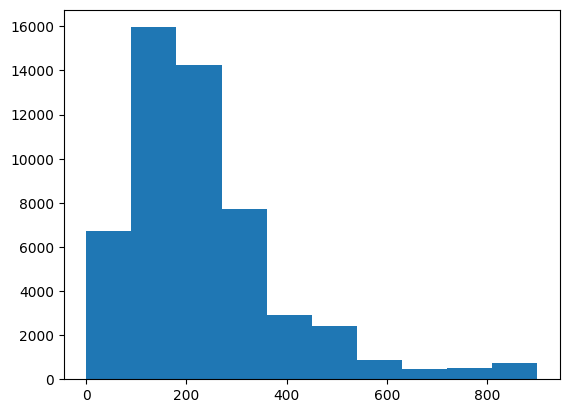

In [23]:
plt.hist(y)

(array([1986., 8022., 9149., 5286., 1985., 1678.,  600.,  307.,  357.,
         518.]),
 array([  0.,  90., 180., 270., 360., 450., 540., 630., 720., 810., 900.]),
 <BarContainer object of 10 artists>)

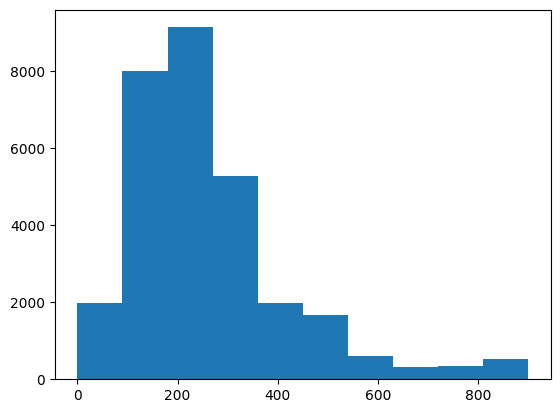

In [24]:
data1=data_clean[data_clean['MS']==1]
plt.hist(data1[['TSPNDFOOD']])

(array([1632., 2746., 1778.,  867.,  337.,  275.,   93.,   44.,   56.,
          77.]),
 array([  0.,  90., 180., 270., 360., 450., 540., 630., 720., 810., 900.]),
 <BarContainer object of 10 artists>)

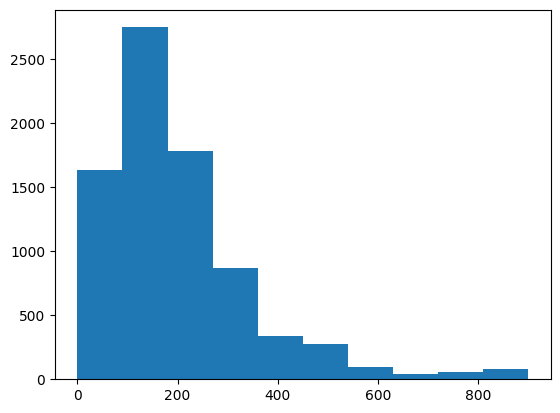

In [25]:
data2=data_clean[data_clean['MS']==3]
plt.hist(data2[['TSPNDFOOD']])